# CNA GHCNh Investigation

Look at trends in the Global Historical Climatology Network hourly (GHCNh) database for the Central US.

In [ ]:
import sys
import os
sys.path.append('../')
from setup import CWD, SCRATCH_DIR, FIG_DIR, DATA_DIR

import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def add_latlon(ax):
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}


Load data. Remember times are in Central Standard Time (CST, -6 UTC). If there are multiple hourly measurements, we take the mean. 

Many stations only record precip data so the number of wind speed stations is far less than the number of potential stations.

In [2]:
GHCNh_file = os.path.join(SCRATCH_DIR, 'GHCNh_cna.csv')
df = (
    pl.scan_csv(GHCNh_file, try_parse_dates=True)
    .sort('time')
    .group_by_dynamic('time', every='1h').agg([
        pl.col(['Station_ID', 'Station_name', 'Latitude', 'Longitude']).first(),
        pl.col(['wind_speed', 'wind_direction']).mean(),
    ])
)
df.head().collect()

metadata = df.select(['Station_ID', 'Station_name', 'Latitude', 'Longitude']).unique().collect()

# Some stations have wrong metadata, manually go in and fix
metadata = metadata.with_columns(
    # Schriever Air Force Base, CO
    Longitude=pl.when(pl.col('Longitude') == -121.1).then(-104.5).otherwise(pl.col('Longitude'))
)
metadata

Station_ID,Station_name,Latitude,Longitude
str,str,f64,f64
"""USW00022001""","""DEL RIO LAUGHLIN AFB""",29.3667,-100.7833
"""USW00012920""","""LAREDO MUNI AP""",27.5333,-99.4667
"""USW00013969""","""PONCA CITY MUNI AP""",36.7369,-97.1022
"""USW00014919""","""JAMESTOWN MUNI AP""",46.9258,-98.6703
"""USW00013934""","""ENGLAND AFB""",31.3167,-92.55
…,…,…,…
"""USW00013998""","""WICHITA RVR""",37.65,-97.3333
"""USW00013984""","""CONCORDIA ASOS""",39.5514,-97.6508
"""USW00014927""","""ST PAUL DWTN AP""",44.9322,-93.0558


## Plot total number of samples by year

Realistically should put this plot after I have a final dataset

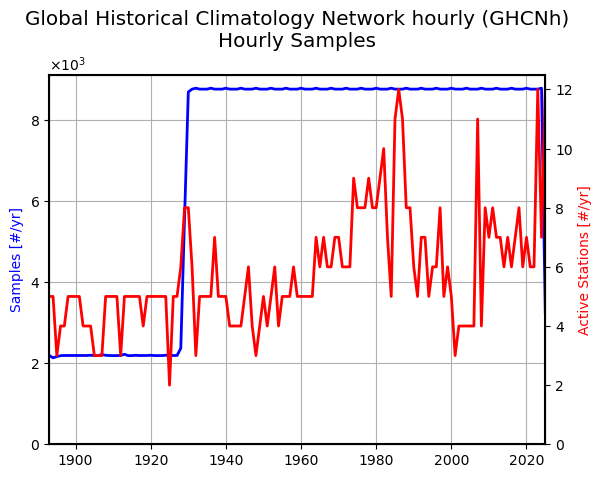

In [5]:
fig, ax = plt.subplots()
year_samples = df.group_by_dynamic('time', every='1y').agg(records=pl.col('wind_speed').len()).collect()
stations_per_year = df.group_by_dynamic('time', every='1y').agg(records=pl.col('Station_ID').unique().len()).collect()

ax.plot(year_samples['time'], year_samples['records'], color='b', lw=2)
ax.grid()
ax.set_ylim(0, None)
ax.set_xlim(year_samples['time'][0], year_samples['time'][-1])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_ylabel('Samples [#/yr]', color='b')
ax.set_title('Global Historical Climatology Network hourly (GHCNh)\nHourly Samples', fontsize='x-large')

ax2 = ax.twinx()
ax2.plot(stations_per_year['time'], stations_per_year['records'], color='r', lw=2)
ax2.set_ylabel('Active Stations [#/yr]', color='r')
ax2.set_ylim(0, None)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

plt.savefig(os.path.join(FIG_DIR, 'GHCNh_number_of_records.png'), dpi=300)
plt.show()

## Filter dataframe to stations with a consistent record
To count as a valid day: `>= 4 measurements`

To count as a valid month: `>= 14 valid days`

To count as a valid year: `>= 11 valid months`

In [6]:
valid_stations = (
    df
    .group_by_dynamic('time', every='1d', group_by='Station_ID')
    .agg(obs_per_day=pl.col('wind_speed').len())
    .filter(pl.col('obs_per_day') >= 4) # remove bad days
    # Cascade into months
    .group_by_dynamic('time', every='1mo', group_by='Station_ID')
    .agg(obs_per_month=pl.col('obs_per_day').len())
    .filter(pl.col('obs_per_month') >= 14) # remove bad months
    # Cascade into years
    .group_by_dynamic('time', every='1y', group_by='Station_ID')
    .agg(obs_per_year=pl.col('obs_per_month').len())
    .filter(pl.col('obs_per_year') >= 11) # remove bad years
    .collect()
)
print(valid_stations.head())
# Now get the number of active years
active_years = (
    valid_stations
    .group_by('Station_ID')
    .agg(num_years=pl.col('obs_per_year').len())
    .filter(pl.col('num_years') >= 5)
    .sort(pl.col('num_years'))
)
ids_sorted = active_years['Station_ID'].to_numpy()
print(active_years.head())
print(f'Number of valid stations: {len(ids_sorted)}')

shape: (5, 3)
┌─────────────┬─────────────────────┬──────────────┐
│ Station_ID  ┆ time                ┆ obs_per_year │
│ ---         ┆ ---                 ┆ ---          │
│ str         ┆ datetime[μs]        ┆ u32          │
╞═════════════╪═════════════════════╪══════════════╡
│ CAN06020LPQ ┆ 2014-01-01 00:00:00 ┆ 12           │
│ CAN06020LPQ ┆ 2015-01-01 00:00:00 ┆ 12           │
│ CAN06020LPQ ┆ 2016-01-01 00:00:00 ┆ 12           │
│ CAN06020LPQ ┆ 2017-01-01 00:00:00 ┆ 12           │
│ CAN06020LPQ ┆ 2018-01-01 00:00:00 ┆ 12           │
└─────────────┴─────────────────────┴──────────────┘
shape: (5, 2)
┌─────────────┬───────────┐
│ Station_ID  ┆ num_years │
│ ---         ┆ ---       │
│ str         ┆ u32       │
╞═════════════╪═══════════╡
│ CAN06020LPQ ┆ 10        │
│ USW00014927 ┆ 14        │
│ USW00014949 ┆ 14        │
│ USW00003957 ┆ 22        │
│ USW00013934 ┆ 25        │
└─────────────┴───────────┘
Number of valid stations: 6


## Stations from GSOM

In [ ]:
gsom_ids = [
    'USW00093058',
     'USW00012916',
     'USW00003937',
     'USW00013985',
     'USW00014935',
     'USW00013967',
     'USW00014944',
     'USW00013970',
     'USW00014920',
     'USW00023047',
     'USW00012924',
     'USW00013957',
     'USW00024025',
     'USW00023042',
     'USW00014943',
     'USW00023065',
     'USW00024032',
     'USW00014929',
     'USW00013966',
     'USW00014940',
     'USW00003940',
     'USW00013968',
     'USW00093037',
     'USW00014926',
     'USW00013963',
     'USW00012919',
     'USW00003945',
     'USW00024028',
     'USW00094908',
     'USW00024090',
     'USW00003928',
     'USW00024018',
     'USW00003947',
     'USW00014918',
     'USW00013962',
     'USW00014936',
     'USW00013995',
     'USW00012912',
     'USW00013964',
     'USW00003927',
     'USW00014914',
     'USW00012960',
     'USW00013996',
     'USW00013958',
     'USW00014939',
     'USW00023009',
     'USW00012917',
     'USW00012921',
     'USW00014942',
     'USW00013984',
     'USW00023034',
     'USW00014923',
     'USW00013959',
     'USW00014922',
     'USW00023023',
     'USW00014925',
     'USW00024011',
     'USW00024023',
     'USW00094910',
     'USW00014991',
     'USW00014913',
     'USW00013994',
     'USW00014941',
     'USW00014933'
]

In [ ]:
# This is temporary for now'
print(ids_sorted)
# metadata.filter(pl.col('Station_ID').str.contains('USW00012920'))
metadata.filter(pl.col('Station_ID') == 'USW00012921')



metadata.filter(pl.col('Station_ID') == gsom_ids[1])

In [ ]:
df.filter(pl.col('Station_ID') == 'USW00012916').collect()

### Plot this

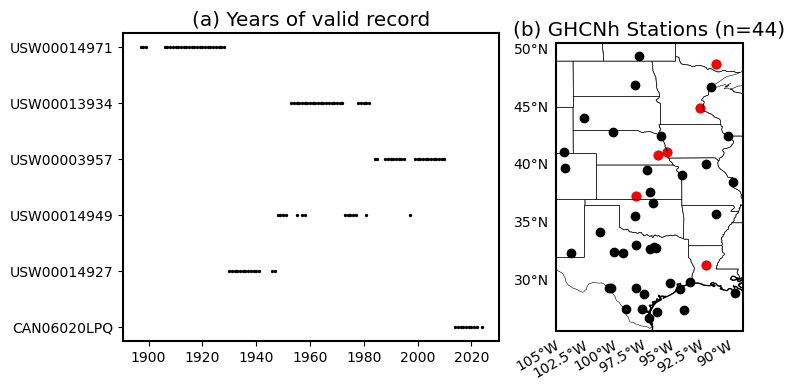

In [7]:
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(ncols=2, width_ratios=[2,1])

# Plot 1: Years of Valid Record
ax = fig.add_subplot(gs[0])
for station in ids_sorted:
    subset = valid_stations.filter(pl.col('Station_ID') == station)
    ax.scatter(subset['time'], subset['Station_ID'], color='k', s=2)
ax.set_title('(a) Years of valid record', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Plot all stations then selected stations
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.scatter(metadata['Longitude'], metadata['Latitude'], transform=ccrs.PlateCarree(), c='k')
metadata_filtered = metadata.filter(pl.col('Station_ID').is_in(ids_sorted))
ax.scatter(metadata_filtered['Longitude'], metadata_filtered['Latitude'], transform=ccrs.PlateCarree(), c='r')
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
add_latlon(ax)
ax.set_title(f'(b) GHCNh Stations (n={len(metadata)})', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.show()

## Look at one station

In [ ]:
def make_monthly(df):
    new_df = (
        df
        .group_by_dynamic('time', every='1d')
        .agg([
            pl.col(['Station_ID', 'Station_name', 'Latitude', 'Longitude']).first(),
            pl.col(['wind_speed', 'wind_direction']).mean(),
        ])
        # Cascade into months
        .group_by_dynamic('time', every='1mo')
        .agg([
            pl.col(['Station_ID', 'Station_name', 'Latitude', 'Longitude']).first(),
            pl.col(['wind_speed', 'wind_direction']).mean(),
        ])
        # Cascade into years
        # .group_by_dynamic('time', every='1y')
        # .agg([
        #     pl.col(['Station_ID', 'Station_name', 'Latitude', 'Longitude']).first(),
        #     pl.col(['wind_speed', 'wind_direction']).mean(),
        # ])
        .collect()
    )
    return new_df

df_s = make_monthly(df.filter(pl.col('Station_ID') == 'USW00012920'))
plt.scatter(df_s['time'], df_s['wind_speed'])

### Split into daytime and nocturnal

Day is `[06, 18)`, night is `[18, 06]`. Filter by day because night goes till the next day so it gets tricky.

In [ ]:
df_diurnal = (
    df
    .filter(pl.col('Station_ID') == 'USW00012920')
    .with_columns(
        day = (pl.col('time').dt.hour() >= 6) & (pl.col('time').dt.hour() < 18)
    )
)

df_day = make_monthly(df_diurnal.filter(pl.col('day') == True))
df_night = make_monthly(df_diurnal.filter(pl.col('day') != True))

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_day['time'], df_day['wind_speed'])
ax.scatter(df_night['time'], df_night['wind_speed'])
ax.grid()
ax.set_ylim(0, None)

plt.show()

In [ ]:
# Need to get same months
same_months_day = df_day.filter(pl.col('time').is_in(same_months_night['time']))
same_months_night = df_night.filter(pl.col('time').is_in(df_day['time']))
fig, ax = plt.subplots()
ax.scatter(same_months_night['time'], same_months_day['wind_speed']-same_months_night['wind_speed'])
ax.grid()
ax.set_ylim(0, None)
ax.set_title('Day - Night')
plt.show()